#Flopy3 Creating Layered Quadtree Grids with GRIDGEN

Flopy3 has a module that can be used to drive the GRIDGEN program.  This notebook shows how it works.

The Flopy GRIDGEN module requires that the gridgen executable can be called using subprocess.

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
from flopy.utils.gridgen import Gridgen

## Setup Base MODFLOW Grid

GRIDGEN works off of a base MODFLOW grid.  The following information defines the basegrid.

In [2]:
Lx = 100.
Ly = 100.
nlay = 2
nrow = 51
ncol = 51
delr = Lx / ncol
delc = Ly / nrow
h0 = 10
h1 = 5
top = h0
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
botm[1, :, :] = -10.

In [3]:
ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(ms, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=top, botm=botm, rotation=20.)

## Create the Gridgen Object

In [4]:
model_ws = os.path.join('.', 'data')
g = Gridgen(dis, model_ws=model_ws)

## Add an Optional Active Domain
Cells outside of the active domain will be clipped and not numbered as part of the final grid.  If this step is not performed, then all cells will be included in the final grid.

In [5]:
# setup the active domain
adshp = os.path.join(model_ws, 'ad0')
adpoly = [[[(0, 0), (0, 60), (40, 80), (60, 0), (0, 0)]]]
# g.add_active_domain(adpoly, range(nlay))

## Refine the Grid

In [6]:
x = Lx * np.random.random(10)
y = Ly * np.random.random(10)
wells = zip(x, y)
g.add_refinement_features(wells, 'point', 3, range(nlay))

In [7]:
river = [[[(-20, 10), (60, 60)]]]
g.add_refinement_features(river, 'line', 3, range(nlay))

In [8]:
g.add_refinement_features(adpoly, 'polygon', 1, range(nlay))

## Build the Grid

In [9]:
g.build()

Error.  Failed to export shared vertex vtk file []


## Plot the Grid

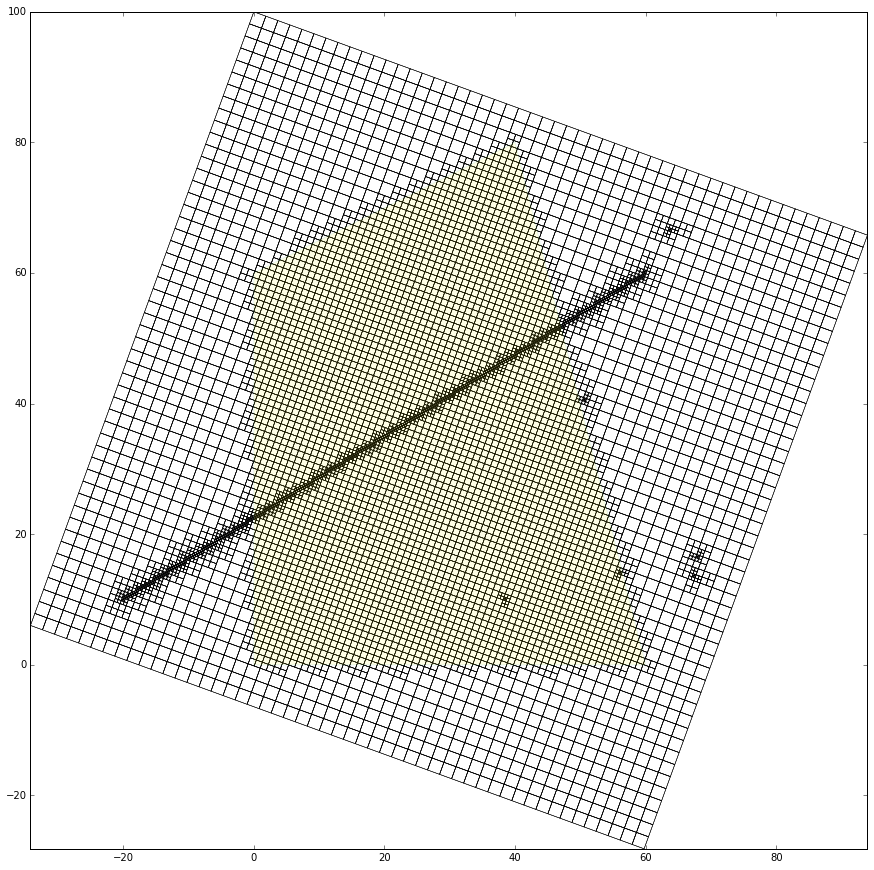

In [10]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5)
flopy.plot.plot_shapefile(adshp, ax=ax, facecolor='yellow', alpha=0.1)

## Create a Flopy ModflowDisu Object

In [11]:
mu = flopy.modflow.Modflow(model_ws=model_ws, modelname='mfusg')
disu = g.get_disu(mu)
# disu.write_file()
# print(disu)

## Intersect Features with the Grid

In [12]:
adpoly_intersect = g.intersect(adpoly, 'polygon', 0)
print(adpoly_intersect.dtype.names)
print(adpoly_intersect)
print(adpoly_intersect['nodenumber'])

('nodenumber', 'polyid', 'totalarea', 'number')
[(183, 0, 0.961169, 0) (241, 0, 0.961169, 0) (184, 0, 0.961169, 0) ...,
 (7208, 0, 0.251054, 0) (7210, 0, 0.512549, 0) (7211, 0, 0.162925, 0)]
[ 183  241  184 ..., 7208 7210 7211]


In [13]:
well_intersect = g.intersect(wells, 'point', 0)
print(well_intersect.dtype.names)
print(well_intersect)
print(well_intersect['nodenumber'])

('nodenumber', 'pointid', 'number')
[(4022, 0, 0) (4223, 2, 2) (4604, 4, 4) (5525, 5, 5) (2371, 6, 6)
 (277, 8, 8)]
[4022 4223 4604 5525 2371  277]


In [14]:
river_intersect = g.intersect(river, 'line', 0)
print(river_intersect.dtype.names)
print(river_intersect)
print(river_intersect['nodenumber'])

('nodenumber', 'arcid', 'length', 'starting_distance', 'ending_distance', 'number')
[(7103, 0, 0.0354838, 0.0, 0.0354838, 0)
 (620, 0, 0.114697, 94.2251, 94.3398, 0)
 (7104, 0, 0.264294, 0.0354838, 0.299778, 0)
 (623, 0, 0.225502, 93.9996, 94.2251, 0)
 (7091, 0, 0.133859, 0.299778, 0.433637, 0)
 (622, 0, 0.0855088, 93.9141, 93.9996, 0)
 (7094, 0, 0.177152, 0.433637, 0.610789, 0)
 (624, 0, 0.311011, 93.6031, 93.9141, 0)
 (7092, 0, 0.221001, 0.610789, 0.83179, 0)
 (756, 0, 0.00163324, 93.6015, 93.6031, 0)
 (7093, 0, 0.0900097, 0.83179, 0.9218, 0)
 (745, 0, 0.309378, 93.2921, 93.6015, 0)
 (7087, 0, 0.308143, 0.9218, 1.22994, 0)
 (747, 0, 0.0887753, 93.2033, 93.2921, 0)
 (7098, 0, 0.0028677, 1.22994, 1.23281, 0)
 (746, 0, 0.222236, 92.9811, 93.2033, 0)
 (7096, 0, 0.311011, 1.23281, 1.54382, 0)
 (752, 0, 0.175917, 92.8052, 92.9811, 0)
 (6964, 0, 0.0842743, 1.54382, 1.6281, 0)
 (749, 0, 0.135094, 92.6701, 92.8052, 0)
 (6965, 0, 0.226737, 1.6281, 1.85483, 0)
 (751, 0, 0.263059, 92.407, 92.670